In [226]:
import json, os

import pandas as pd
import numpy as np

from scipy.stats import boxcox

from datetime import datetime
import matplotlib.pyplot as plt

### Here's a JSON Reader Function

In [227]:
def read_axe_jsons(axe_num):
    with open('axe_listings/%s' % (axe_num), "r") as read_file:
        listing = json.load(read_file)
    with open('axe_specs/%s' % (axe_num), "r") as read_file:
        specs = json.load(read_file)
    return {'listing': listing, 'specs': specs}

### Here's a Guitar (Axe) Class with Lots of Attributes (Features)

Some ducking was required for auctions without certain details.

In [236]:
class Axe:
    def __init__(self, axe_num=None):
        self.id = axe_num
        self.__body = read_axe_jsons("%s" % (axe_num))
        self.price_usd = float(self.__body['listing']['sellingStatus'][0]['convertedCurrentPrice'][0]['__value__'])
        self.title = self.__body['listing']['title'][0]
        self.market = self.__body['listing']['globalId'][0]
        if self.__body['listing'].get('galleryURL'):
            self.pic = self.__body['listing']['galleryURL'][0]
        else: self.pic = None
        
        if self.__body['listing'].get("pictureURLLarge"):
            self.pic_big = self.__body['listing']['pictureURLLarge'][0]
        else:
            self.pic_big = None
        
        self.url = self.__body['listing']['viewItemURL'][0]
        self.autopay = self.__body['listing']['autoPay'][0] == 'true'
        self.country_seller = self.__body['listing']['country'][0]
        self.ship_type = self.__body['listing']['shippingInfo'][0]['shippingType'][0]
        self.ship_expedite = self.__body['listing']['shippingInfo'][0]['expeditedShipping'][0] == 'true'
        
        if self.__body['listing']['shippingInfo'][0].get('handlingTime'):
            self.ship_handling_time = int(self.__body['listing']['shippingInfo'][0]['handlingTime'][0])
        else: 
            self.ship_handling_time = None
        
        self.zip = self.__body['listing'].get('postalCode')
        
        self.start_time = datetime.strptime(self.__body['listing']['listingInfo'][0]['startTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        self.end_time = datetime.strptime(self.__body['listing']['listingInfo'][0]['endTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        
        self.start_weekday = self.start_time.weekday()
        self.end_weekday = self.end_time.weekday()
        
        self.__duration = (self.end_time - self.start_time)
        self.duration = round(float(self.__duration.days*24) + float(self.__duration.seconds/60/60), 2)
        
        self.returns = self.__body['listing']['returnsAccepted'][0] == 'true'
        
        # End Generic Section // Begin Specs Section:
        
        if self.__body['specs'].get('Description'):
            self.description = self.__body['specs']['Description']
        else:
            self.description = None
        
        self.pic_quantity = len(self.__body['specs']['PictureURL'])
        self.seller_feedback_score = float(self.__body['specs']['Seller']['FeedbackScore'])
        self.seller_positive_percent = float(self.__body['specs']['Seller']['PositiveFeedbackPercent'])
        self.subtitle = self.__body['specs'].get('Subtitle')
        self.condition_description = self.__body['specs'].get('ConditionDescription')
        
        # Niche niche specifics:
        
        if self.returns:
            if self.__body['specs']['ReturnPolicy'].get('ReturnsWithin'):
                self.returns_time = int(self.__body['specs']['ReturnPolicy'].get('ReturnsWithin').split()[0])
        else: self.returns_time = None
            
        # Very ultra niche specifics, more ducking required:
        
        if self.__body['specs'].get('ItemSpecifics'):
            self.__attrs = {prop['Name']:prop['Value'][0] 
                            for prop in self.__body['specs']['ItemSpecifics']['NameValueList']}
            self.brand = self.__attrs.get('Brand')
            self.model = self.__attrs.get('Model')
            
            if self.__attrs.get('Model Year'):
                self.year = self.__attrs.get('Model Year')[:4]
            else: self.year = None
                
            self.material = self.__attrs.get('Body Material')
            self.right_left_hand = self.__attrs.get('Right-/ Left-Handed')
            self.country_manufacture = self.__attrs.get('Country/Region of Manufacture')
            self.body_type = self.__attrs.get('Body Type')
            self.string_config = self.__attrs.get('String Configuration')
            self.color = self.__attrs.get('Body Color')
        else:
            self.__attrs = self.brand = self.model = self.year = None
            self.material = self.right_left_hand = self.country_manufacture = None
            self.body_type = self.string_config = self.color = None    

### Loop Through All Guitar JSON Data Files, Instantiate AXE Class Objects

In [237]:
filenames = [name for name in os.listdir('axe_specs/') if not name.startswith('.')] # Ignore .DS_Store

In [238]:
axes = [Axe(filename) for filename in filenames]

In [239]:
len(axes)

6045

********

## EDA

**********

__Price Distribution:__

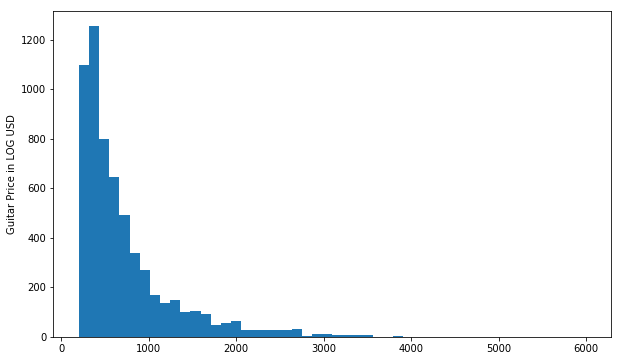

In [240]:
plt.figure(figsize = (10,6))
plt.hist([axe.price_usd for axe in axes], bins=50)
plt.ylabel('Guitar Price in LOG USD')
plt.show()

**Box-Cox Transformed Price Distribution:**

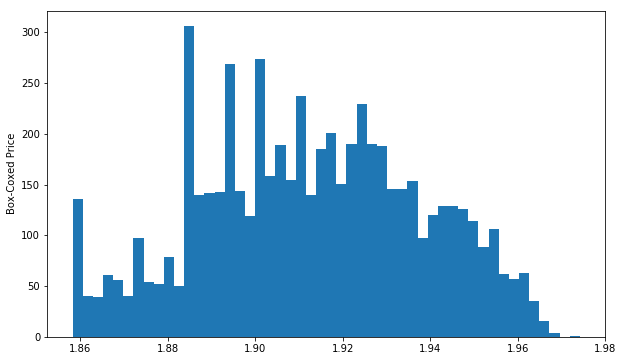

In [241]:
plt.figure(figsize = (10,6))
plt.hist(boxcox(np.array([axe.price_usd for axe in axes]), -.5), bins=50)
plt.ylabel('Box-Coxed Price')
plt.show()

**********

__Text Fields, for NLP:__

In [197]:
[axe.title for axe in axes][:10]

['Paul Reed Smith Custom 24 Anniversary Blue Maple Quilt',
 'Reverend Volcano Electric Guitar - Used, Mint Condition - w/Hard Shell Case',
 '1982 Fender Fullerton ‘62 Reissue Stratocaster, No. V008495 Collector Features!',
 ' Fender American Standard Telecaster w/ Original Case',
 'PRS SE 245 Amber Flame Top',
 'Epiphone Joe Pass Emperor II Electric Guitar (MIK)',
 'Vintage 1978 Aria Pro II LC 550 Custom LP Electric Guitar-Japan',
 'Godin 5th Avenue Uptown GT LTD - Silver Gold - Premium Preowned',
 "Reverend Super Rev Electric Guitar - '69 Yellow - Premium Preowned",
 'Reverend Kyle Shutt Signature Electric Guitar - Ice White - Premium Preowned']

In [179]:
mean_title_len = sum(len(axe.title) for axe in axes)/len(axes)
mean_title_len

57.87544752214057

In [204]:
[axe.condition_description for axe in axes if axe.condition_description != None][50:60]

['two cavity covers on back missing, two latches on case broken',
 'Guitar has been repaired where the endpin is located.It plays great and rings true across fret board.',
 'marks and scuffs',
 'Excellent',
 'beautiful guitar!!!',
 'This is used but in good functional condition. One switch tip is broken, there is peeling finish on the fretboard, and there are two cracks near the nut. Please see photos and item description for additional details.',
 'Guitar Works.Missing Volume Knob.Pickups Work.Comes With A Gig Bag.',
 'NICE CONDITION MARKS OF USE + 50 YEARS. 100 % FUNCIONAL. SEE PICTURES',
 'Used but great condition',
 'Barely used!! Pretty much new. Only played it a few times.']

Percent of listings that include a text condition description field:

In [210]:
len([axe.condition_description for axe in axes if axe.condition_description != None]) / len(axes)

0.2771810815903524

***********

__Number of Pics on eBay listing:__

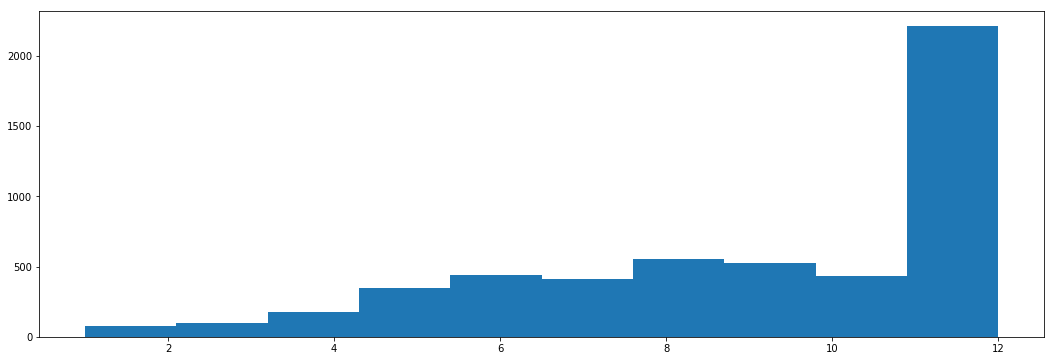

In [152]:
plt.figure(figsize = (18,6))
plt.hist([axe.pic_quantity for axe in axes])
plt.show()

__Thumbnail Image URLs__ — for Potential (CNN, maybe) Image Analysis as a factor in price

In [153]:
[axe.pic for axe in axes][:5] # Just first five. You get it

['http://thumbs2.ebaystatic.com/m/m0D2-zv9uYmDdJZuT1Gxz9w/140.jpg',
 'http://thumbs3.ebaystatic.com/m/mf_K9CJ9oMxzGCTxnspjDaA/140.jpg',
 'http://thumbs3.ebaystatic.com/m/mhYMjKmDarwSAil8hum9isA/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mB7X0lxYCR3TDZ7A4kPM7kw/140.jpg',
 'http://thumbs1.ebaystatic.com/m/mMM1eWXYE96GRVXYWKrggcQ/140.jpg']

**********

**Shipping Type:**

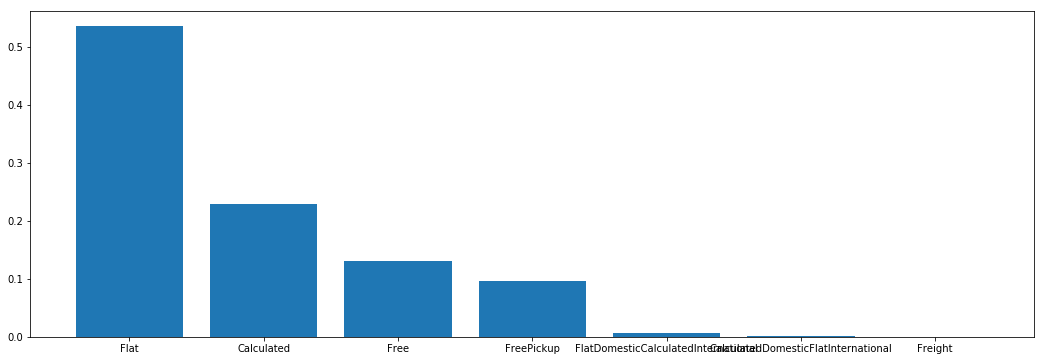

In [154]:
plt.figure(figsize = (18,6))
ship_counts = pd.Series([axe.ship_type for axe in axes]).value_counts()
plt.bar(ship_counts.index, ship_counts.values/len(axes))
plt.show()

**Handling Time in Days:**

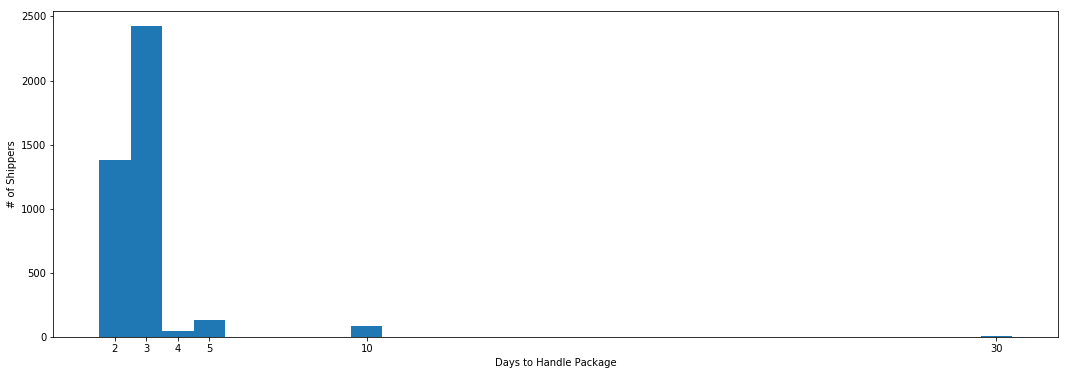

In [161]:
plt.figure(figsize = (18,6))
times = [axe.ship_handling_time for axe in axes if axe.ship_handling_time != None]
plt.hist(times, bins=np.arange(max(times))+1.5)
plt.xticks([2,3,4,5,10,30])
plt.xlabel('Days to Handle Package')
plt.ylabel('# of Shippers')
plt.show()

__Duration of Auction in Days__:

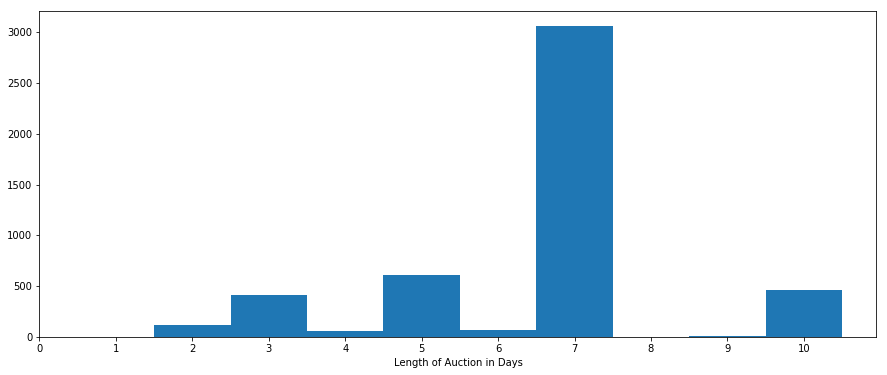

In [162]:
plt.figure(figsize = (15,6))
plt.hist([axe.duration/24 for axe in axes], bins = np.arange(10)+1.5)
plt.xticks(range(11))
plt.xlabel('Length of Auction in Days')
plt.show()

***

**Distribution of Countries of Sellers:**

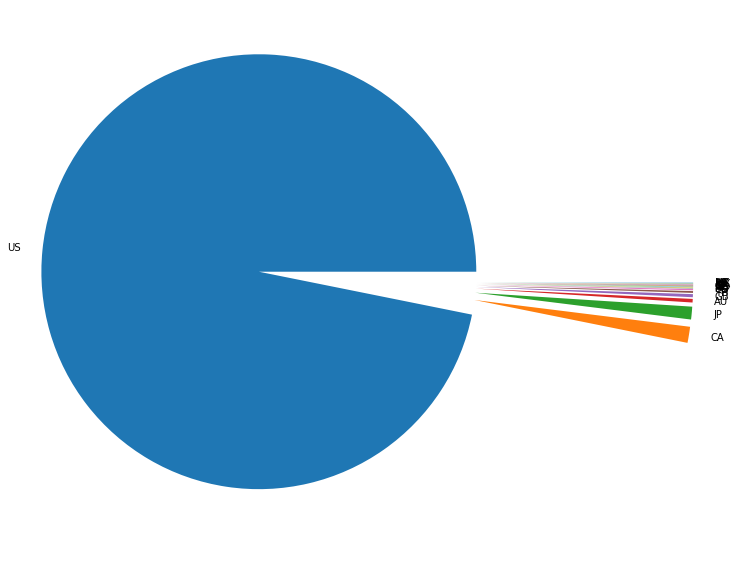

In [163]:
plt.figure(figsize = (10,10))
countries = pd.Series([axe.country_seller for axe in axes]).value_counts()
plt.pie(countries.values, labels=countries.index, explode = np.full(len(countries), .5))
plt.show()

Probably want to just exclude non-USA sellers.

***

**Offering Expedited Shipping:**

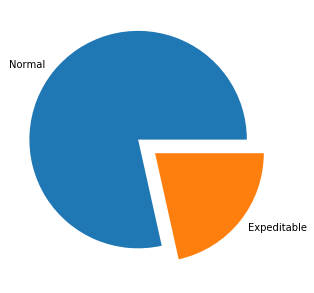

In [164]:
exp = pd.Series([axe.ship_expedite for axe in axes]).value_counts()
plt.figure(figsize = (5,5))
plt.pie(exp.values, explode=[.1,.1], labels=['Normal', 'Expeditable'])
plt.show()

***********

**Starting Weekday:**

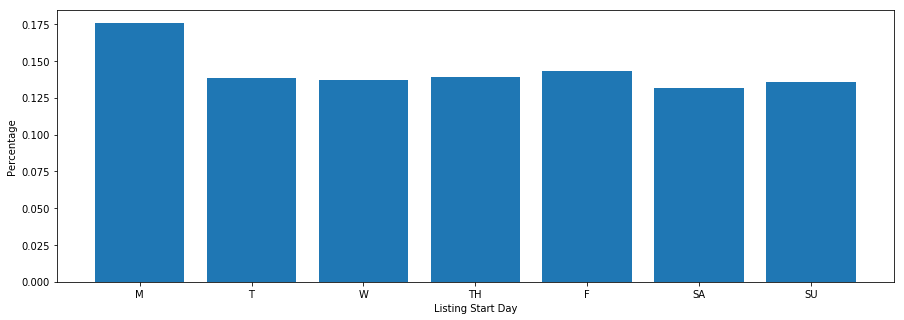

In [165]:
days = pd.Series([axe.start_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.xlabel("Listing Start Day")
plt.ylabel('Percentage')
plt.show()

**Ending Weekday:**

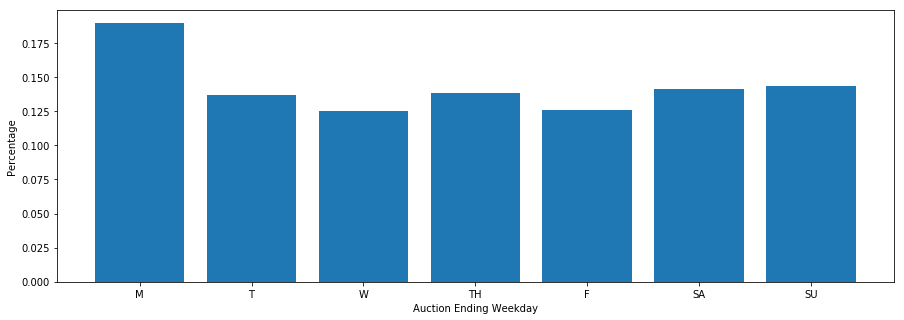

In [166]:
days = pd.Series([axe.end_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.ylabel('Percentage')
plt.xlabel("Auction Ending Weekday")
plt.show()

****

**Percentage Offering Returns:**

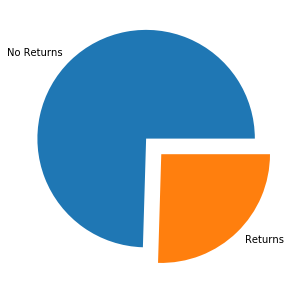

In [167]:
returns = pd.Series([axe.returns for axe in axes]).value_counts()
plt.figure(figsize = (5,5))
plt.pie(returns.values, explode=[.1,.1], labels=['No Returns', 'Returns'])
plt.show()

****

**Return Time Windows** of sellers offering returns:

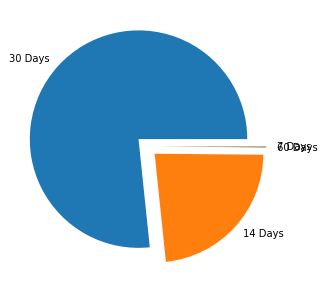

In [172]:
returns = pd.Series([axe.returns_time for axe in axes if axe.returns_time != None]).value_counts()
plt.figure(figsize = (5,5))
plt.pie(returns.values, explode=[.1,.1,.1,.1], labels = ['30 Days', '14 Days', '60 Days', '7 Days'])
plt.show()

***

__Guitar Body Colors:__

In [186]:
pd.Series([axe.color for axe in axes if axe.color != None]).value_counts()[:20]

Black               532
White               254
Red                 253
Blue                176
Sunburst            135
Brown                83
Natural              81
Gold                 69
Green                62
Multicolor           58
Orange               38
Yellow               31
Silver               28
Clear                27
Purple               26
Cherry               26
Gray                 19
Tobacco Sunburst     19
Ebony                17
Vintage Sunburst     16
dtype: int64

In [195]:
per = round((sum(pd.Series([axe.color for axe in axes if axe.color != None]).value_counts() / len(axes))*100),2)
print(f'{per}% of listings include a body color where they\'re supposed to.')

55.4% of listings include a body color where they're supposed to.
